In [56]:
#pip install tensorflow

In [57]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [58]:
df = pd.read_excel("dataset_final.xlsx", parse_dates=['TANGGAL'])
df = df.sort_values('TANGGAL')
df = df.reset_index(drop=True)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   TANGGAL  3983 non-null   datetime64[ns]
 1   TN       3983 non-null   float64       
 2   TX       3983 non-null   float64       
 3   TAVG     3983 non-null   float64       
 4   RH_AVG   3983 non-null   float64       
 5   RR       3983 non-null   float64       
 6   SS       3983 non-null   float64       
 7   FF_X     3983 non-null   int64         
 8   DDD_X    3983 non-null   int64         
 9   FF_AVG   3983 non-null   int64         
 10  DDD_CAR  3983 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 342.4 KB


In [60]:
def add_safe_features(df):
    df = df.copy()

    # Date components
    df['month'] = df['TANGGAL'].dt.month
    df['day']   = df['TANGGAL'].dt.day

    df['month_sin'] = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)
    df['day_sin']   = np.sin(2*np.pi*df['day']/31)
    df['day_cos']   = np.cos(2*np.pi*df['day']/31)

    df['temp_range'] = df['TX'] - df['TN']

    def month_to_season(m):
        if m in [12,1,2]: return 1
        elif m in [3,4,5]: return 2
        elif m in [6,7,8]: return 3
        else: return 4
    df['season'] = df['month'].apply(month_to_season)

    return df

df = add_safe_features(df)


In [61]:
train = df[df['TANGGAL'] < '2024-01-01']
val   = df[(df['TANGGAL'] >= '2024-01-01') & (df['TANGGAL'] < '2025-01-01')]
test  = df[df['TANGGAL'] >= '2025-01-01']


In [62]:
def add_leakage_safe_lags(train, val, test):
    # Digabung, tapi rolling hanya dari bagian TRAIN
    full = pd.concat([train, val, test], axis=0)

    full['RR_lag1']  = full['RR'].shift(1)
    full['RR_lag7']  = full['RR'].shift(7)
    full['TAVG_lag1'] = full['TAVG'].shift(1)

    full['RR_diff1'] = full['RR'] - full['RR_lag1']
    full['RH_diff1'] = full['RH_AVG'] - full['RH_AVG'].shift(1)

    full['RR_7d']  = full['RR'].rolling(7).mean()
    full['RR_30d'] = full['RR'].rolling(30).mean()

    full['Rain_7d_count'] = full['RR'].apply(lambda x: 1 if x > 0 else 0).rolling(7).sum()

    # Setelah fitur selesai → split kembali
    train2 = full.loc[train.index]
    val2   = full.loc[val.index]
    test2  = full.loc[test.index]

    return train2, val2, test2

train, val, test = add_leakage_safe_lags(train, val, test)


In [63]:
train = train.dropna()
val   = val.dropna()
test  = test.dropna()


In [64]:
features = [
    'TN','TX','TAVG','RH_AVG','SS','FF_X','DDD_X','FF_AVG','DDD_CAR',
    'RR_lag1','RR_lag7','TAVG_lag1','RR_diff1','RH_diff1',
    'RR_7d','RR_30d','Rain_7d_count',
    'month_sin','month_cos','day_sin','day_cos','temp_range','season'
]

X_train = train[features]
y_train = train['RR']

X_val = val[features]
y_val = val['RR']

X_test = test[features]
y_test = test['RR']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


In [65]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    random_state=42
)
rf.fit(X_train_scaled, y_train)

pred_rf = rf.predict(X_val_scaled)


mse = mean_squared_error(y_val, pred_rf)      # default mengembalikan MSE
rmse = np.sqrt(mse)
print("RF MAE:", mean_absolute_error(y_val, pred_rf))
print("RF RMSE:", rmse)


RF MAE: 0.5902544461178755
RF RMSE: 1.488355336630911


In [66]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)
xgb.fit(X_train_scaled, y_train)

pred_xgb = xgb.predict(X_val_scaled)

print("XGB MAE:", mean_absolute_error(y_val, pred_xgb))



XGB MAE: 0.6747502367283095


In [67]:
# reshape → (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_lstm   = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))


In [68]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

pred_lstm = model.predict(X_val_lstm)
print("LSTM MAE:", mean_absolute_error(y_val, pred_lstm))



Epoch 1/50


c:\Users\Lenovo E15\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 274.5818 - val_loss: 196.8992
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 173.2194 - val_loss: 107.8981
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.8497 - val_loss: 49.2355
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.0278 - val_loss: 20.7719
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.5326 - val_loss: 12.7681
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.9377 - val_loss: 8.6493
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.3709 - val_loss: 6.4899
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.6317 - val_loss: 5.5129
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.8408 - val_loss: 4.1932
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.9994 - val_loss: 3.5176
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.4242 - val_loss: 3.2455
Epoch 12/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s

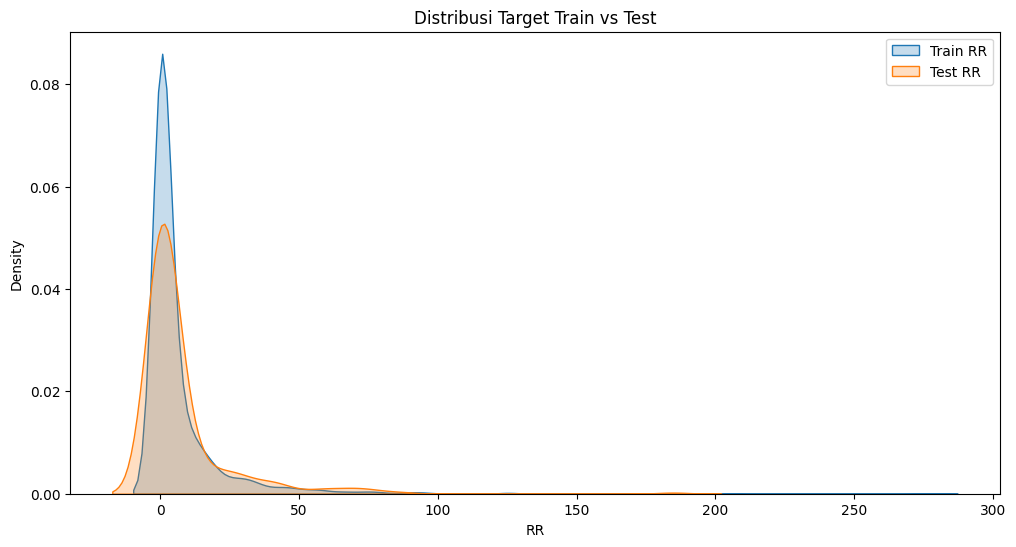

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.kdeplot(y_train, label='Train RR', fill=True)
sns.kdeplot(y_test, label='Test RR', fill=True)
plt.title("Distribusi Target Train vs Test")
plt.legend()
plt.show()


In [76]:
import pandas as pd
import numpy as np

corr = pd.concat([X_train, y_train], axis=1).corr()
target_corr = corr['RR'].sort_values(ascending=False)

print("Korelasi Fitur dengan Target:")
print(target_corr)


Korelasi Fitur dengan Target:
RR               1.000000
RR_diff1         0.630036
RR_7d            0.488391
RH_AVG           0.398956
RR_30d           0.343350
Rain_7d_count    0.274881
RR_lag1          0.205991
month_sin        0.193677
month_cos        0.131767
DDD_X            0.102883
RR_lag7          0.100149
RH_diff1         0.045427
FF_X             0.010541
DDD_CAR          0.009763
day_cos         -0.000262
FF_AVG          -0.002136
day_sin         -0.010720
temp_range      -0.059846
season          -0.190939
SS              -0.196614
TAVG_lag1       -0.311592
TX              -0.322064
TAVG            -0.390053
TN              -0.392616
Name: RR, dtype: float64


In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

pred_train_rf = rf.predict(X_train_scaled)
pred_test_rf = rf.predict(X_test_scaled)

train_rmse = np.sqrt(mean_squared_error(y_train, pred_train_rf))
test_rmse  = np.sqrt(mean_squared_error(y_test, pred_test_rf))

train_mae = mean_absolute_error(y_train, pred_train_rf)
test_mae  = mean_absolute_error(y_test, pred_test_rf)

print("RF Train RMSE:", train_rmse)
print("RF Test RMSE :", test_rmse)
print("RF Train MAE:", train_mae)
print("RF Test MAE :", test_mae)


RF Train RMSE: 1.7322311818862517
RF Test RMSE : 2.344089907143265
RF Train MAE: 0.3300130905316924
RF Test MAE : 0.8278103857282862


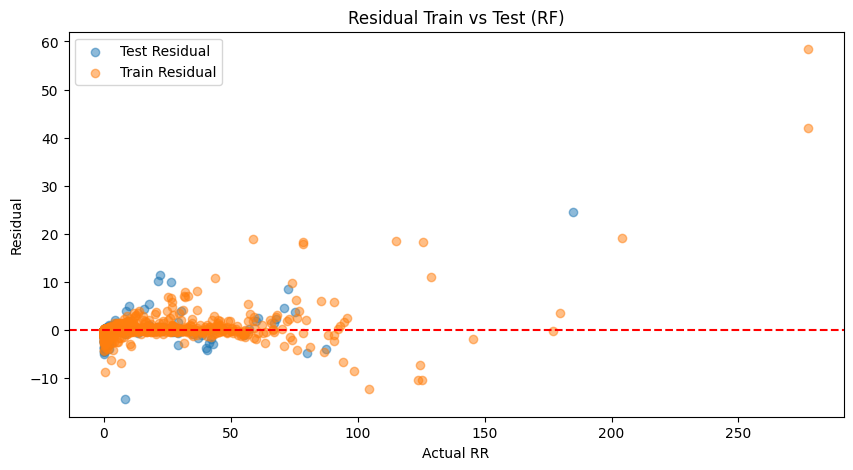

In [78]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_test - pred_test_rf, alpha=0.5, label="Test Residual")
plt.scatter(y_train, y_train - pred_train_rf, alpha=0.5, label="Train Residual")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual RR")
plt.ylabel("Residual")
plt.legend()
plt.title("Residual Train vs Test (RF)")
plt.show()


In [70]:
df.tail(10)

,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR,month,day,month_sin,month_cos,day_sin,day_cos,temp_range,season
3973,2025-11-01,24.4,34.4,29.3,73.0,43.6,8.0,3,140,1,0,11,1,-0.5,0.866025,0.201299,0.979530,10.0,4
3974,2025-11-02,25.2,33.4,29.6,73.0,0.0,6.8,4,340,1,0,11,2,-0.5,0.866025,0.394356,0.918958,8.2,4
3975,2025-11-03,26.8,33.6,28.8,73.0,0.0,6.2,4,120,1,0,11,3,-0.5,0.866025,0.571268,0.820763,6.8,4
3976,2025-11-04,26.2,34.4,29.8,73.0,0.0,5.7,3,290,1,0,11,4,-0.5,0.866025,0.724793,0.688967,8.2,4
3977,2025-11-05,26.4,33.4,29.4,68.0,4.2,6.5,4,240,1,0,11,5,-0.5,0.866025,0.848644,0.528964,7.0,4
3978,2025-11-06,27.2,33.2,29.4,71.0,0.0,2.4,4,260,2,225,11,6,-0.5,0.866025,0.937752,0.347305,6.0,4
3979,2025-11-07,27.2,34.2,29.4,75.0,0.0,2.3,3,280,1,0,11,7,-0.5,0.866025,0.988468,0.151428,7.0,4
3980,2025-11-08,26.6,29.6,27.5,81.0,0.0,6.0,4,250,2,225,11,8,-0.5,0.866025,0.998717,-0.050649,3.0,4
3981,2025-11-09,26.2,34.5,30.8,66.0,12.4,4.5,5,240,3,225,11,9,-0.5,0.866025,0.968077,-0.250653,8.3,4
3982,2025-11-10,27.4,33.7,29.9,68.0,0.0,6.7,5,220,2,225,11,10,-0.5,0.866025,0.897805,-0.440394,6.3,4


In [71]:
target_date = '2025-11-01'
row = test[test['TANGGAL'] == target_date]

row_scaled = scaler.transform(row[features])

# 3 model predictions
pred_rf_5  = rf.predict(row_scaled)[0]
pred_xgb_5 = xgb.predict(row_scaled)[0]
pred_lstm_5 = model.predict(row_scaled.reshape(1,1,-1))[0][0]

print("Prediksi Curah Hujan : ")
print("RF  :", pred_rf_5)
print("XGB :", pred_xgb_5)
print("LSTM:", pred_lstm_5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediksi Curah Hujan : 
RF  : 43.720409999999994
XGB : 41.77636
LSTM: 45.83145


In [72]:
target_date = '2025-11-10'
row = test[test['TANGGAL'] == target_date]

print(row)
print("Jumlah baris:", len(row))


        TANGGAL    TN    TX  TAVG  RH_AVG   RR   SS  FF_X  DDD_X  FF_AVG  ...  \
3982 2025-11-10  27.4  33.7  29.9    68.0  0.0  6.7     5    220       2  ...   

      temp_range  season  RR_lag1  RR_lag7  TAVG_lag1  RR_diff1  RH_diff1  \
3982         6.3       4     12.4      0.0       30.8     -12.4       2.0   

         RR_7d  RR_30d  Rain_7d_count  
3982  2.371429    8.27            2.0  

[1 rows x 27 columns]
Jumlah baris: 1


# Predict Future (Forecast)

In [73]:
def create_future_row(df, future_date):
    """
    df          : dataframe lengkap setelah feature engineering aman (date features, season, etc)
    future_date : string 'YYYY-MM-DD'
    """
    future_date = pd.to_datetime(future_date)

    # --- 1. Ambil 30 hari terakhir
    last_30 = df.tail(30).copy()

    # --- 2. Ambil hari terakhir sebagai baseline future
    last_row = df.iloc[-1].copy()

    # --- 3. Buat row baru
    future_row = last_row.copy()
    future_row['TANGGAL'] = future_date

    # ------------------------------------------
    # 4. DATE FEATURES
    # ------------------------------------------
    future_row['month'] = future_date.month
    future_row['day']   = future_date.day

    # Cyclic encoding
    future_row['month_sin'] = np.sin(2*np.pi * future_row['month'] / 12)
    future_row['month_cos'] = np.cos(2*np.pi * future_row['month'] / 12)
    future_row['day_sin']   = np.sin(2*np.pi * future_row['day'] / 31)
    future_row['day_cos']   = np.cos(2*np.pi * future_row['day'] / 31)

    # Temperature range
    future_row['temp_range'] = future_row['TX'] - future_row['TN']

    # Season
    def month_to_season(m):
        if m in [12,1,2]: return 1
        if m in [3,4,5]: return 2
        if m in [6,7,8]: return 3
        return 4

    future_row['season'] = month_to_season(future_row['month'])

    # ------------------------------------------
    # 5. Gabungkan 30 hari terakhir + 1 future
    #    supaya rolling dan lag bisa dihitung
    # ------------------------------------------
    temp = pd.concat([last_30, pd.DataFrame([future_row])], ignore_index=True)

    # LAG
    temp['RR_lag1']   = temp['RR'].shift(1)
    temp['RR_lag7']   = temp['RR'].shift(7)
    temp['TAVG_lag1'] = temp['TAVG'].shift(1)

    temp['RR_diff1'] = temp['RR'] - temp['RR_lag1']
    temp['RH_diff1'] = temp['RH_AVG'] - temp['RH_AVG'].shift(1)

    # Rolling
    temp['RR_7d']  = temp['RR'].rolling(7).mean()
    temp['RR_30d'] = temp['RR'].rolling(30).mean()

    # Rain count 7 days
    temp['Rain_7d_count'] = temp['RR'].apply(lambda x: 1 if x > 0 else 0).rolling(7).sum()

    # Ambil row terakhir = future row siap pakai
    future_ready = temp.iloc[-1:]

    return future_ready


In [74]:
def predict_future(df, future_date, features, scaler, rf, xgb, lstm_model):
    # buat fitur untuk future date
    future_row = create_future_row(df, future_date)

    # scaling
    future_scaled = scaler.transform(future_row[features])

    # RF
    pred_rf = rf.predict(future_scaled)[0]

    # XGB
    pred_xgb = xgb.predict(future_scaled)[0]

    # LSTM (reshape 3D)
    pred_lstm = lstm_model.predict(future_scaled.reshape(1,1,-1))[0][0]

    return {
        "date": future_date,
        "RF": pred_rf,
        "XGB": pred_xgb,
        "LSTM": pred_lstm
    }


In [75]:
future_date = "2025-11-11"

result = predict_future(
    df=df,
    future_date=future_date,
    features=features,
    scaler=scaler,
    rf=rf,
    xgb=xgb,
    lstm_model=model
)

print("Prediksi RR pada", result["date"])
print("Random Forest :", result["RF"])
print("XGBoost       :", result["XGB"])
print("LSTM          :", result["LSTM"])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediksi RR pada 2025-11-11
Random Forest : 1.2532167459646977e-06
XGBoost       : -0.033519138
LSTM          : -0.037825644
